# Предсказание стоимости жилья

В проекте нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных необходимо предсказать медианную стоимость дома в жилом массиве, обучить модель и сделать предсказания на тестовой выборке. Для оценки качества модели использовать метрики RMSE, MAE и R2.

*Примечание к выполнению задания:* 
- для чтения и манипуляциями с данными использовать методы pySpark;
- построить две модели линейной регрессии на разных наборах данных:
    - используя все данные из файла;
    - используя только числовые переменные, исключив категориальные
- для построения модели использовать оценщик LinearRegression из библиотеки MLlib.

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
import pyspark.sql.functions as F

import pyspark.mllib as ml
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# инициализация локальной Spark-сессии
spark = SparkSession.builder \
                    .master('local') \
                    .appName('Housing in California DataFrames') \
                    .getOrCreate()

In [2]:
# чтение файла
housing_california = spark.read.load('/datasets/housing.csv', format='csv', inferSchema=True, header=True)
housing_california.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [3]:
# проверка на пропущенные значения
columns = housing_california.columns

for column in columns:
    check_columns = F.col(column).isNull()
    print(column, housing_california.filter(check_columns).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [4]:
# первые 10 строк
housing_california.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [5]:
# описательные статистики
columns = [
    'housing_median_age', 'total_rooms', 'total_bedrooms',
     'population', 'households', 'median_income', 'median_house_value'
]

housing_california.describe(columns).show(truncate=12)

for col in columns:
    print(col, housing_california.approxQuantile(col, [0.05, 0.95], 0))

+-------+------------------+------------+--------------+------------+------------+-------------+------------------+
|summary|housing_median_age| total_rooms|total_bedrooms|  population|  households|median_income|median_house_value|
+-------+------------------+------------+--------------+------------+------------+-------------+------------------+
|  count|             20640|       20640|         20433|       20640|       20640|        20640|             20640|
|   mean|      28.639486...|2635.7630...|  537.87055...|1425.4767...|499.53968...| 3.8706710...|      206855.81...|
| stddev|      12.585557...|2181.6152...|  421.38507...|1132.4621...|382.32975...| 1.8998217...|      115395.61...|
|    min|               1.0|         2.0|           1.0|         3.0|         1.0|       0.4999|           14999.0|
|    max|              52.0|     39320.0|        6445.0|     35682.0|      6082.0|      15.0001|          500001.0|
+-------+------------------+------------+--------------+------------+---

**Описание данных:**
- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

- набор данных состоит из 10 столбцов и 20 640 строк;
- в столбце `total_bedrooms` обнаружено 207 пропущенных значений, которые необходимо обработать;
- столбец `ocean_proximity` имеет тип данных `string`, остальные - тип `double`;
- столбцы `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income` содержат аномальные значения, которые необходимо обработать;
- целевой признак - `median_house_value`.

## Предобработка и исследовательский анализ данных

- *линейная корреляция признаков:*

In [6]:
housing_california_df = housing_california.toPandas()

In [7]:
assembler = VectorAssembler(inputCols=columns, outputCol='features', handleInvalid='skip')
vectorized_features = assembler.transform(housing_california).select('features')

correlation = Correlation.corr(vectorized_features, 'features', 'pearson').collect()[0][0]

22/08/01 07:39:35 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/08/01 07:39:35 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [8]:
rows = correlation.toArray().tolist()
spark.createDataFrame(rows, columns).show(truncate=10)

+------------------+-----------+--------------+----------+----------+-------------+------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+------------------+-----------+--------------+----------+----------+-------------+------------------+
|               1.0| -0.3606...|    -0.3204...|-0.2957...|-0.3027...|   -0.1182...|        0.10643...|
|        -0.3606...|        1.0|    0.93037...|0.85728...|0.91899...|   0.19788...|        0.13329...|
|        -0.3204...| 0.93037...|           1.0|0.87774...|0.97972...|   -0.0077...|        0.04968...|
|        -0.2957...| 0.85728...|    0.87774...|       1.0|0.90718...|   0.00508...|        -0.0252...|
|        -0.3027...| 0.91899...|    0.97972...|0.90718...|       1.0|   0.01343...|        0.06489...|
|        -0.1182...| 0.19788...|    -0.0077...|0.00508...|0.01343...|          1.0|        0.68835...|
|        0.10643...| 0.13329...|    0.04968...|-0.0252...|0.06489...|   0

***Вывод:*** между целевым признаком медианной стоимости дома в жилом массиве и медианным доходом жителей жилого массива наблюдается достаточно сильная линейная зависимость; между остальными признаками и целевым признаком линейных зависимостей не обнаружено. При этом есть сильно выраженная линейная зависимость между признаками.

- *построение гистограмм и замена аномальных значений:*

In [9]:
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_theme(style="whitegrid")

Text(0.5, 1.0, 'Histogram of housing median age')

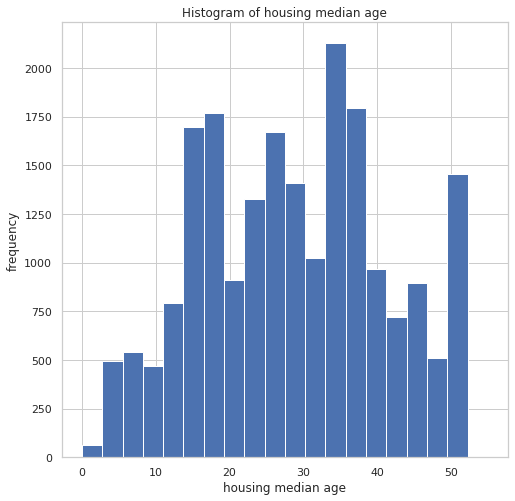

In [10]:
housing_california_df['housing_median_age'].hist(bins=20, range=(0, 55))
plt.xlabel('housing median age')
plt.ylabel('frequency')
plt.title('Histogram of housing median age')

Text(0.5, 1.0, 'Histogram of total rooms')

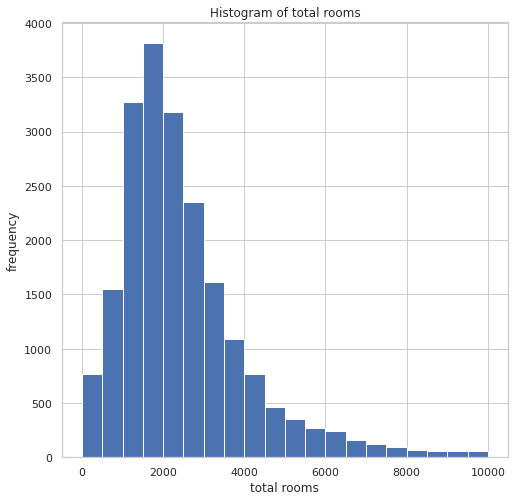

In [11]:
housing_california_df['total_rooms'].hist(bins=20, range=(0, 10000))
plt.xlabel('total rooms')
plt.ylabel('frequency')
plt.title('Histogram of total rooms')

Text(0.5, 1.0, 'Histogram of total bedrooms')

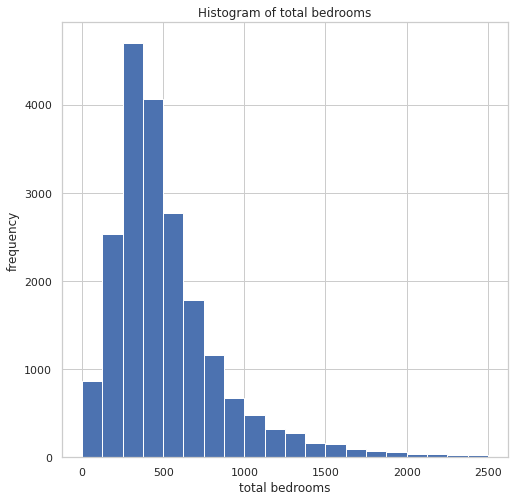

In [12]:
housing_california_df['total_bedrooms'].hist(bins=20, range=(0, 2500))
plt.xlabel('total bedrooms')
plt.ylabel('frequency')
plt.title('Histogram of total bedrooms')

Text(0.5, 1.0, 'Histogram of population')

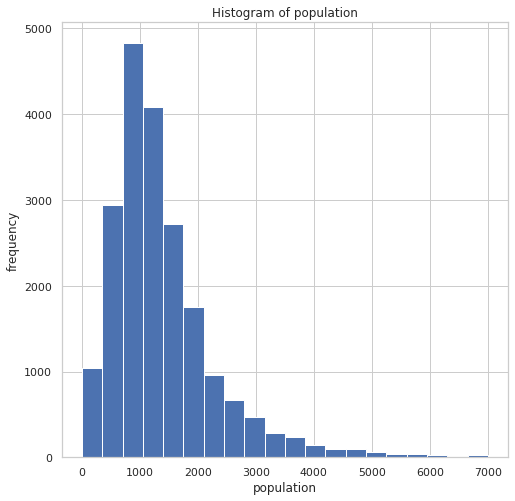

In [13]:
housing_california_df['population'].hist(bins=20, range=(0, 7000))
plt.xlabel('population')
plt.ylabel('frequency')
plt.title('Histogram of population')

Text(0.5, 1.0, 'Histogram of households')

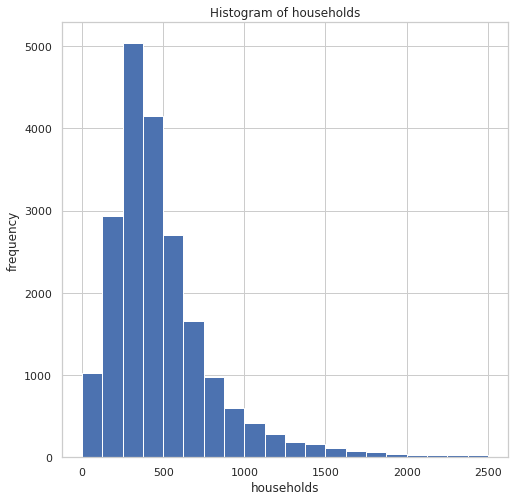

In [14]:
housing_california_df['households'].hist(bins=20, range=(0, 2500))
plt.xlabel('households')
plt.ylabel('frequency')
plt.title('Histogram of households')

Text(0.5, 1.0, 'Histogram of median income')

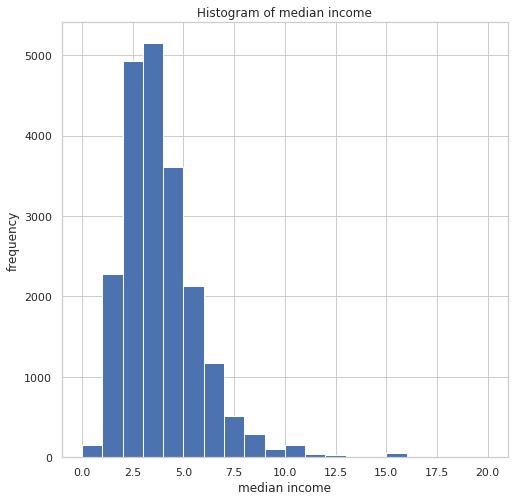

In [15]:
housing_california_df['median_income'].hist(bins=20, range=(0, 20))
plt.xlabel('median income')
plt.ylabel('frequency')
plt.title('Histogram of median income')

***Вывод:***
- значения в столбце `housing_median_age` не имеют нормального распределения, присутствует множество пиковых значений, 32 года - самый часто встречаемый медианный возраст в жилых массивах;
- в колонках `total_rooms`, `total_bedrooms`, `population`,`households`, `median_income` данные распределены нормально, скошены вправо и имеют аномальные значения. 

In [16]:
numeric_columns = [
    'housing_median_age', 'total_rooms', 
    'total_bedrooms', 'population',
    'households', 'median_income'
]

In [17]:
# замена аномальных значений 5-м и 95-м процентилями
for column in numeric_columns:
    q_5, q_95 = housing_california.approxQuantile(column, [0.05, 0.95], 0)
    print(column, q_5, q_95)
    filter_func = F.when(
        housing_california[column] < q_5, q_5
    ).when(
        housing_california[column] > q_95, q_95
    ).otherwise(
        housing_california[column]
    )
    housing_california = housing_california.withColumn(column, filter_func)

housing_median_age 8.0 52.0
total_rooms 620.0 6213.0
total_bedrooms 137.0 1276.0
population 348.0 3288.0
households 125.0 1162.0
median_income 1.6 7.3003


In [18]:
# поверка, что аномальные значения заменились на нужные процентили
housing_california.describe(columns).show(truncate=12)

+-------+------------------+------------+--------------+------------+------------+-------------+------------------+
|summary|housing_median_age| total_rooms|total_bedrooms|  population|  households|median_income|median_house_value|
+-------+------------------+------------+--------------+------------+------------+-------------+------------------+
|  count|             20640|       20640|         20433|       20640|       20640|        20640|             20640|
|   mean|      28.769186...|2484.1645...|  511.19243...|1352.9354...|475.59118...| 3.7873885...|      206855.81...|
| stddev|      12.350934...|1449.0360...|  296.97352...|775.08586...|270.67742...| 1.5627794...|      115395.61...|
|    min|               8.0|       620.0|         137.0|       348.0|       125.0|          1.6|           14999.0|
|    max|              52.0|      6213.0|        1276.0|      3288.0|      1162.0|       7.3003|          500001.0|
+-------+------------------+------------+--------------+------------+---

- *замена пропущенных значений в колонке `total_bedrooms` на медиану:*

In [19]:
total_bedrooms_median = housing_california_df['total_bedrooms'].median()
total_bedrooms_median

435.0

In [20]:
housing_california = housing_california.fillna({'total_bedrooms': total_bedrooms_median})

- *удаление столбцов с широтой и долготой:*

In [21]:
exclude = ['longitude', 'latitude']
selected_columns = [col for col in housing_california.columns if col not in exclude]

housing_california = housing_california.select(selected_columns)
housing_california.show(5)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|              41.0|      880.0|         137.0|     348.0|     126.0|       7.3003|          452600.0|       NEAR BAY|
|              21.0|     6213.0|        1106.0|    2401.0|    1138.0|       7.3003|          358500.0|       NEAR BAY|
|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|              52.0|     1627.0|         280.0|     565.0|     259.0|       3.8462|          342200.0|       NEAR BAY|
+------------------+-----------+--------------+-

- *добавление новых признаков для обучения модели:*

In [22]:
# отношение количества комнат к количеству домовладений
housing_california = housing_california.withColumn(
    'rooms_per_household', 
    F.round(F.col('total_rooms') / F.col('households'), 2)
)

# отношение количества жителей к количеству домовладений
housing_california = housing_california.withColumn(
    'population_in_household',
    F.round(F.col('population') / F.col('households'), 2)
)

# отношение количества спален к общему количеству комнат
housing_california = housing_california.withColumn(
    'bedroom_index',
    F.round(F.col('total_bedrooms') / F.col('total_rooms'), 2)
)

housing_california.printSchema()
housing_california.show(5)

root
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+-----------------------+-------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|rooms_per_household|population_in_household|bedroom_index|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----

## Обучение моделей с помощью MLlib

In [23]:
# числовые признаки
numeric_columns = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                   'households', 'median_income', 'rooms_per_household',
                   'population_in_household', 'bedroom_index'
                  ]

In [24]:
# категориальные признаки
categorial_columns = ['ocean_proximity']

In [25]:
# целевой признак
target = 'median_house_value'

In [26]:
RANDOM_STATE=123

### Преобразование категориальных признаков

In [27]:
indexer = StringIndexer(inputCol='ocean_proximity', outputCol='ocean_proximity_idx')

housing_california = indexer.fit(housing_california).transform(housing_california)


cols = [c for c in housing_california.columns for i in categorial_columns if (c.startswith(i))]
housing_california.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
+---------------+-------------------+
only showing top 3 rows



In [28]:
encoder = OneHotEncoder(inputCol='ocean_proximity_idx',
                       outputCol='ocean_proximity_ohe'
                       )
housing_california = encoder.fit(housing_california).transform(housing_california)

cols = [c for c in housing_california.columns for i in categorial_columns if (c.startswith(i))]
housing_california.select(cols).show(3)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



In [29]:
categorial_assembler = VectorAssembler(
    inputCols=[c+'_ohe' for c in categorial_columns],
    outputCol='categorial_features'
)
housing_california = categorial_assembler.transform(housing_california)

cols = [c for c in housing_california.columns for i in categorial_columns if (c.startswith(i))]
housing_california.select(cols + ['categorial_features']).show(3)

+---------------+-------------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorial_features|
+---------------+-------------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+-------------------+
only showing top 3 rows



### Преобразование числовых признаков

In [30]:
numeric_assembler = VectorAssembler(inputCols=numeric_columns, outputCol='numeric_features')
housing_california = numeric_assembler.transform(housing_california)

In [31]:
housing_california.select(['numeric_features']).show(2)

+--------------------+
|    numeric_features|
+--------------------+
|[41.0,880.0,137.0...|
|[21.0,6213.0,1106...|
+--------------------+
only showing top 2 rows



In [32]:
standardScaler = StandardScaler(inputCol='numeric_features', outputCol='numeric_features_scaler')
housing_california = standardScaler.fit(housing_california).transform(housing_california)

In [33]:
housing_california.select(['numeric_features_scaler']).show(2)

+-----------------------+
|numeric_features_scaler|
+-----------------------+
|   [3.31958680986533...|
|   [1.70027617090663...|
+-----------------------+
only showing top 2 rows



In [34]:
print(housing_california.columns)

['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity', 'rooms_per_household', 'population_in_household', 'bedroom_index', 'ocean_proximity_idx', 'ocean_proximity_ohe', 'categorial_features', 'numeric_features', 'numeric_features_scaler']


In [35]:
all_features = ['categorial_features', 'numeric_features_scaler']

final_assembler = VectorAssembler(inputCols = all_features, outputCol='features') 
housing_california = final_assembler.transform(housing_california)

housing_california.select('features').show(5) 

+--------------------+
|            features|
+--------------------+
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
+--------------------+
only showing top 5 rows



In [36]:
housing_california.select('numeric_features_scaler').show(5)

+-----------------------+
|numeric_features_scaler|
+-----------------------+
|   [3.31958680986533...|
|   [1.70027617090663...|
|   [4.21020766129261...|
|   [4.21020766129261...|
|   [4.21020766129261...|
+-----------------------+
only showing top 5 rows



### Разделение на выборки

In [37]:
features_train, features_test = housing_california.randomSplit([.8,.2], seed=RANDOM_STATE)
print(features_train.count(), features_test.count()) 

16442 4198


### GridSearch и кросс-валидация

- *обучение модели на всем наборе данных:*

In [40]:
model_lr = LinearRegression(
    labelCol=target,
    featuresCol='features'
)

In [41]:
grid_search = ParamGridBuilder().addGrid(
    model_lr.regParam, [0.0, 0.05, 0.2, 1.0]
).addGrid(
    model_lr.elasticNetParam, [0.5, 1.0]
).build()

In [42]:
evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol=target)

In [43]:
cv = CrossValidator(estimator=model_lr,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=RANDOM_STATE
                   )
cv_model = cv.fit(features_train)

22/06/02 19:03:19 WARN Instrumentation: [aa88175d] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:03:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/06/02 19:03:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/06/02 19:03:24 WARN Instrumentation: [cebcc776] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:03:33 WARN Instrumentation: [c59a2a9b] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:03:36 WARN Instrumentation: [16bd8c99] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:03:43 WARN Instrumentation: [a2656178] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:03:46 WARN Instrumentation: [4fc14797] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:03:52 WARN In

In [44]:
cv_model.bestModel.summary.meanAbsoluteError

50595.97818525096

In [45]:
cv_model.bestModel.extractParamMap()

{Param(parent='LinearRegression_ca37117fbde7', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_ca37117fbde7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LinearRegression_ca37117fbde7', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_ca37117fbde7', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_ca37117fbde7', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_ca37117fbde7', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_ca37117fbde7', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 

- *обучение модели только на числовых признаках:*

In [46]:
model_lr_num = LinearRegression(
    labelCol=target,
    featuresCol='numeric_features_scaler'
)

In [47]:
grid_search = ParamGridBuilder().addGrid(
    model_lr_num.regParam, [0.0, 0.05, 0.2, 1.0]
).addGrid(
    model_lr_num.elasticNetParam, [0.5, 1.0]
).build()

In [48]:
evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol=target)

In [49]:
cv = CrossValidator(estimator=model_lr_num,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=RANDOM_STATE
                   )
cv_model = cv.fit(features_train)

22/06/02 19:04:11 WARN Instrumentation: [c2d41977] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:13 WARN Instrumentation: [f67118ed] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:18 WARN Instrumentation: [750242b8] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:20 WARN Instrumentation: [30c35149] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:25 WARN Instrumentation: [beabd1c4] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:26 WARN Instrumentation: [f5243c5f] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:30 WARN Instrumentation: [0f29f678] regParam is zero, which might cause numerical instability and overfitting.
22/06/02 19:04:32 WARN Instrumentation: [3995f32c] regParam is zero, which might cause numerical instability and overf

In [50]:
cv_model.bestModel.summary.meanAbsoluteError

54306.721868414264

In [51]:
cv_model.bestModel.extractParamMap()

{Param(parent='LinearRegression_090aea45c74e', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_090aea45c74e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5,
 Param(parent='LinearRegression_090aea45c74e', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_090aea45c74e', name='featuresCol', doc='features column name.'): 'numeric_features_scaler',
 Param(parent='LinearRegression_090aea45c74e', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_090aea45c74e', name='labelCol', doc='label column name.'): 'median_house_value',
 Param(parent='LinearRegression_090aea45c74e', name='loss', doc='The loss function to be optimized. Supported options: squaredEr

### Обучение модели линейной регрессии 

- *обучение модели на всем наборе данных:*

In [52]:
model_lr = LinearRegression(
    elasticNetParam=0.5,
    regParam=0.0,
    labelCol=target,
    featuresCol='features'
)

model = model_lr.fit(features_train) 

22/06/02 19:04:43 WARN Instrumentation: [ce62e11f] regParam is zero, which might cause numerical instability and overfitting.


- *обучение модели только на числовых признаках:*

In [53]:
model_lr_num = LinearRegression(
    elasticNetParam=0.5,
    regParam=0.0,
    labelCol=target,
    featuresCol='numeric_features_scaler'
)

model_num = model_lr_num.fit(features_train)

22/06/02 19:04:44 WARN Instrumentation: [36818366] regParam is zero, which might cause numerical instability and overfitting.


### Предсказание модели на тестовой выборке

In [54]:
# модель обучена на всех признаках
predictions = model.transform(features_test)

predictedLabes = predictions.select(target, 'prediction')
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           55000.0|15524.619210379688|
|          500001.0|  93027.1558361482|
|          500001.0|136549.13347842632|
|          187500.0|  67253.8408388214|
|          164800.0| 92042.48384317069|
|          187500.0|171091.72419562956|
|          270800.0|208305.72623513054|
|          500001.0|150724.11285847498|
|          141700.0|183644.58950281524|
|          107500.0|199049.55170376514|
|          181300.0|260722.94651123052|
|          281700.0| 340553.6648145119|
|          500001.0| 359608.5265761597|
|          432400.0|368971.51569090766|
|           87500.0|  83040.1149928836|
|          225000.0|179576.14009337092|
|           96300.0|150391.65828084075|
|          165500.0|  256465.636974822|
|          151500.0|236307.69480824386|
|          220700.0| 246252.8179551602|
+------------------+------------------+
only showing top 20 rows



In [55]:
# модель обучена только на числовых признаках
predictions_num = model_num.transform(features_test)

predictedLabes = predictions_num.select(target, 'prediction')
predictedLabes.show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           55000.0|22968.279675240425|
|          500001.0|44113.676822595444|
|          500001.0| 81671.72309048471|
|          187500.0| 84996.43205821197|
|          164800.0|114720.32268013191|
|          187500.0|137720.36158373774|
|          270800.0|182343.41440804742|
|          500001.0| 185085.0587433748|
|          141700.0|224559.77491989787|
|          107500.0|243031.75869954677|
|          181300.0|245196.54121771254|
|          281700.0|326292.14764320955|
|          500001.0| 363769.5573130009|
|          432400.0| 374996.6528943187|
|           87500.0|20802.325111655315|
|          225000.0|150245.39891374813|
|           96300.0| 180381.6031308614|
|          165500.0|225702.80536743035|
|          151500.0| 200638.8317749564|
|          220700.0|209896.40698936002|
+------------------+------------------+
only showing top 20 rows



### Оценка качества

- значения метрик `R2`, `MAE`, `RMSE` модели, обученной на всех признаках:

In [56]:
r2 = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predictions)

mae = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predictions)

rmse = RegressionEvaluator(labelCol=target, metricName='rmse').evaluate(predictions)

print('R2 модели, обученной на всех признаках: ', r2)
print('MAE модели, обученной на всех признаках: ', mae)
print('RMSE модели, обученной на всех признаках: ', rmse)

R2 модели, обученной на всех признаках:  0.6457462576443941
MAE модели, обученной на всех признаках:  50728.648107214
RMSE модели, обученной на всех признаках:  68374.88669373763


- значения метрик `R2`, `MAE`, `RMSE` модели, обученной только на числовых признаках:

In [57]:
r2 = RegressionEvaluator(labelCol=target, metricName='r2').evaluate(predictions_num)

mae = RegressionEvaluator(labelCol=target, metricName='mae').evaluate(predictions_num)

rmse = RegressionEvaluator(labelCol=target, metricName='rmse').evaluate(predictions_num)

print('R2 модели, обученной только на числовых признаках: ', r2)
print('MAE модели, обученной только на числовых признаках: ', mae)
print('RMSE модели, обученной только на числовых признаках: ', rmse)

R2 модели, обученной только на числовых признаках:  0.5934526018980995
MAE модели, обученной только на числовых признаках:  54522.893527295695
RMSE модели, обученной только на числовых признаках:  73247.868142295


In [58]:
# закрытие spark-сессии
spark.stop()

# Анализ результатов

Обучение модели линейной регрессии на различных наборах данных показало следующие результаты:
- *значения метрик (коэффициент детерминации R2, средняя абсолютная ошибка MAE и корень среднего квадрата ошибок RMSE) получились лучше у модели, обученной на всех признаках - категориальных и числовых.*

Но при этом, значение метрики R2 равное 0.6457 далеко от единицы, что делает обученную модель не сильно лучше случайной. Метрика MAE показывает, что модель, в среднем, ошибается на 50 тыс. в расчете прогноза стоимости жилья.

Возможно, данные для обучения "сырые" и требуют тщательной обработки. В процессе подготовки данных мне удалось обнаружить выбросы, которые я заменила 5-м и 95-м процентилями, а так же нулевые значения в столбце, которые заменила медианой. Эти действия позволили поднять метрику R2 на 5%.

Для улучшения предсказательной способности модели необходим подбор гиперпараметров, добавление новых признаков для обучения.